# 211013 Analysis

In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import h5py as h5
from tqdm import tqdm

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Setup

In [39]:
infiles = dict(
    data=Path('data-intermediate/211014-combine-data/data.nc')
)

## Code

In [ ]:
def get_datasets(group):
    return {name: child[:] for name, child in group.items()}

In [ ]:
def with_dims(ds, dims):
    todrop = ds.dims.keys() - dims
    return ds.drop_dims(todrop)

## Load data

### Common

In [40]:
common_ds = xr.load_dataset(infiles['data'], group='common')

common_df = common_ds.to_dataframe(['data_set', 'param'])

In [41]:
gsets = common_ds.indexes['data_set']

### Params

In [193]:
params_df = common_ds \
    .drop_dims('data_set') \
    .to_dataframe() \
    .set_index(['prefix_len', 'prefix_version', 'k'], drop=True)

In [198]:
def get_param(prefix_len, prefix_version, k):
    return params_df.index.get_loc((prefix_len, prefix_version, k))

In [199]:
gambitdb_param = get_param(5, 0, 11)

### By genome

In [42]:
genome_dss = {gset: xr.load_dataset(infiles['data'], group='genome/' + gset) for gset in gsets}

## Clustering

In [225]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

In [182]:
def pairs_to_matrix(xa, dim1, dim2):
    assert xa.ndim == 1
    g1 = xa.coords['g1']
    g2 = xa.coords['g2']
    n = g1.max().item() + 1
    
    mat = np.empty((n, n), dtype=xa.dtype)
    mat[g1, g2] = xa.values
    mat[g2, g1] = xa.values
    
    return xr.DataArray(mat, dims=[dim1, dim2])

In [230]:
def leaf_order(link):
    return dendrogram(link, no_plot=True)['leaves']

In [231]:
def order_dmat(dmat, link):
    leaves = leaf_order(link)
    return dmat[np.ix_(leaves, leaves)]

### ?

In [224]:
for ds in genome_dss.values():
    ds['ani_dmat'] = 1 - pairs_to_matrix(ds['ani_mean'], 'genome', 'genome2')

    ds['gambit_dmat'] = ds['dist'] \
        .groupby('param') \
        .map(lambda d: pairs_to_matrix(d, 'genome', 'genome2'))

In [234]:
ds = genome_dss['snitkin_2012']

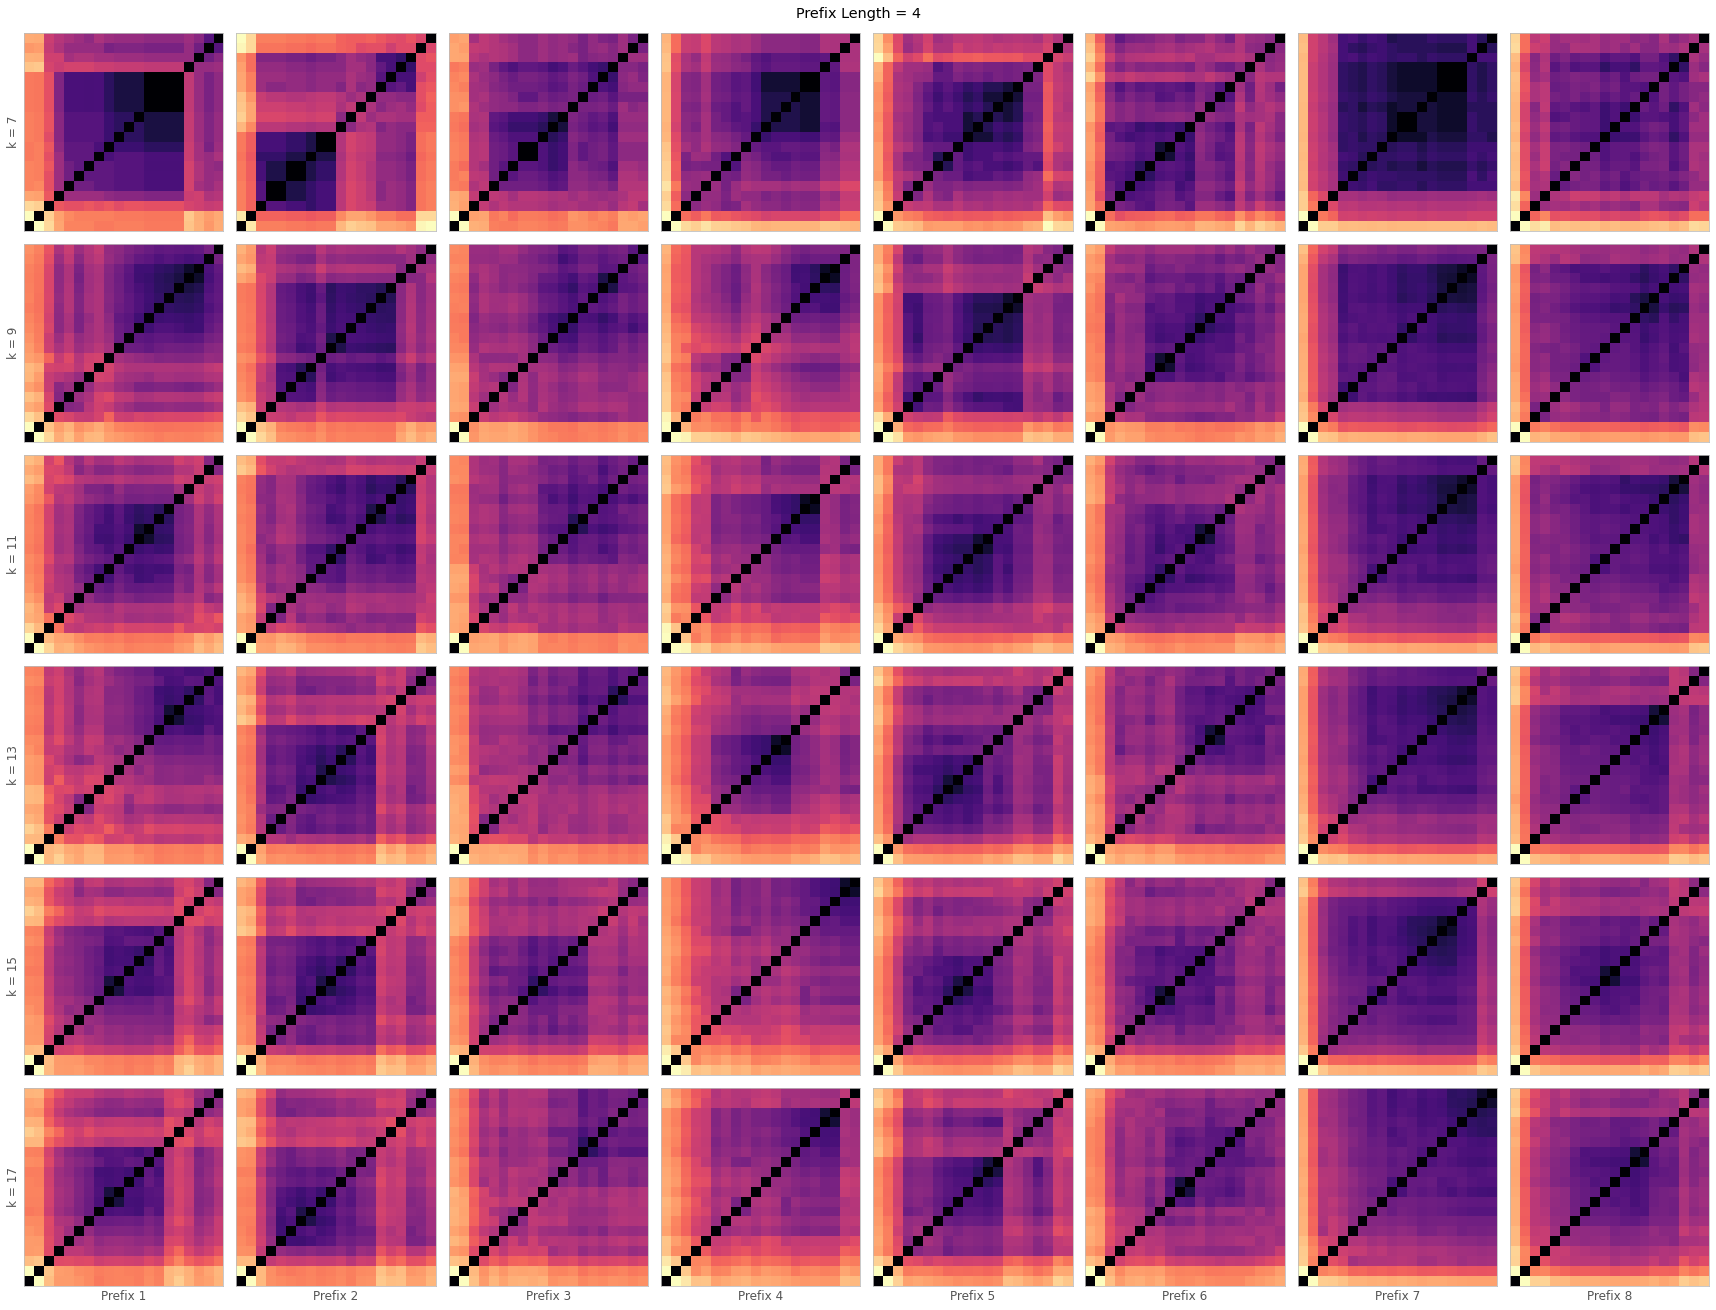

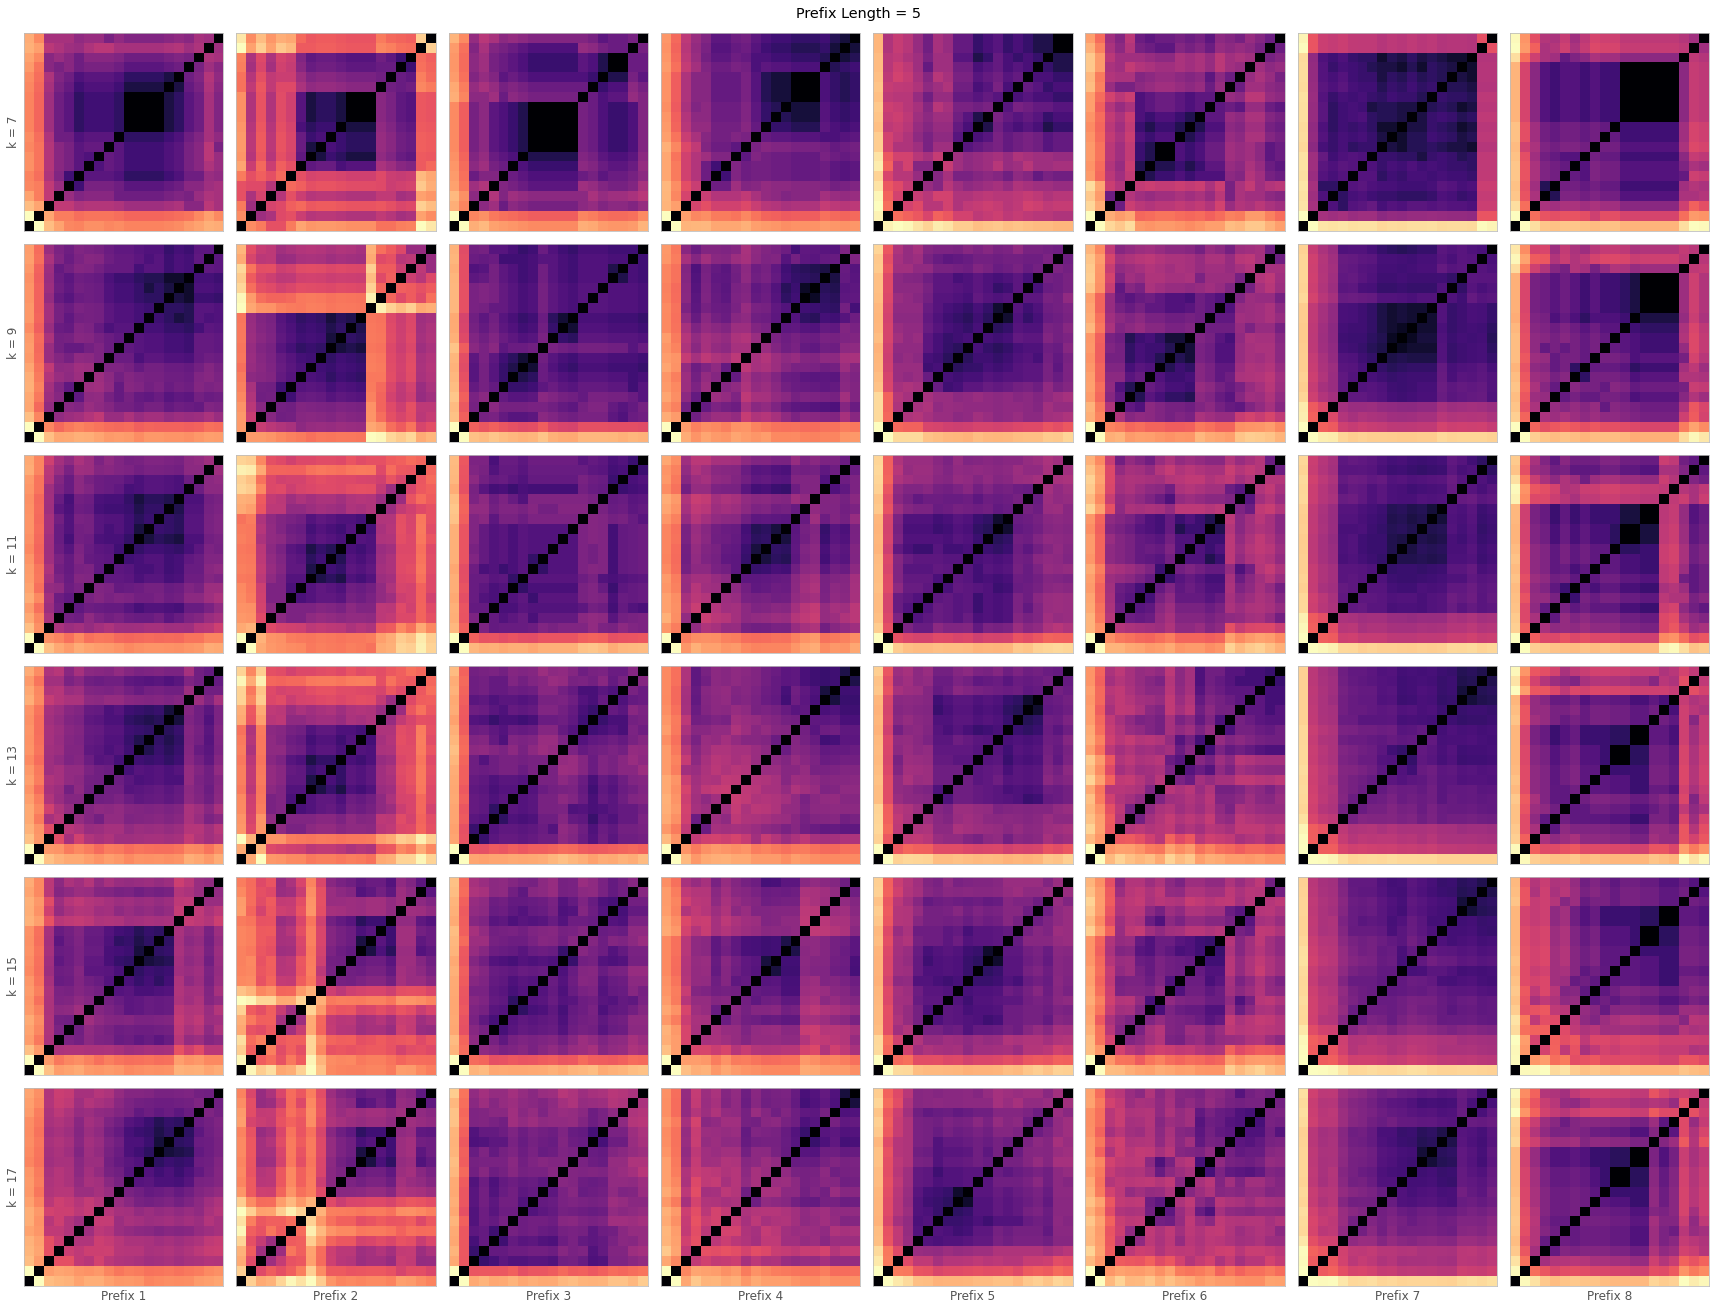

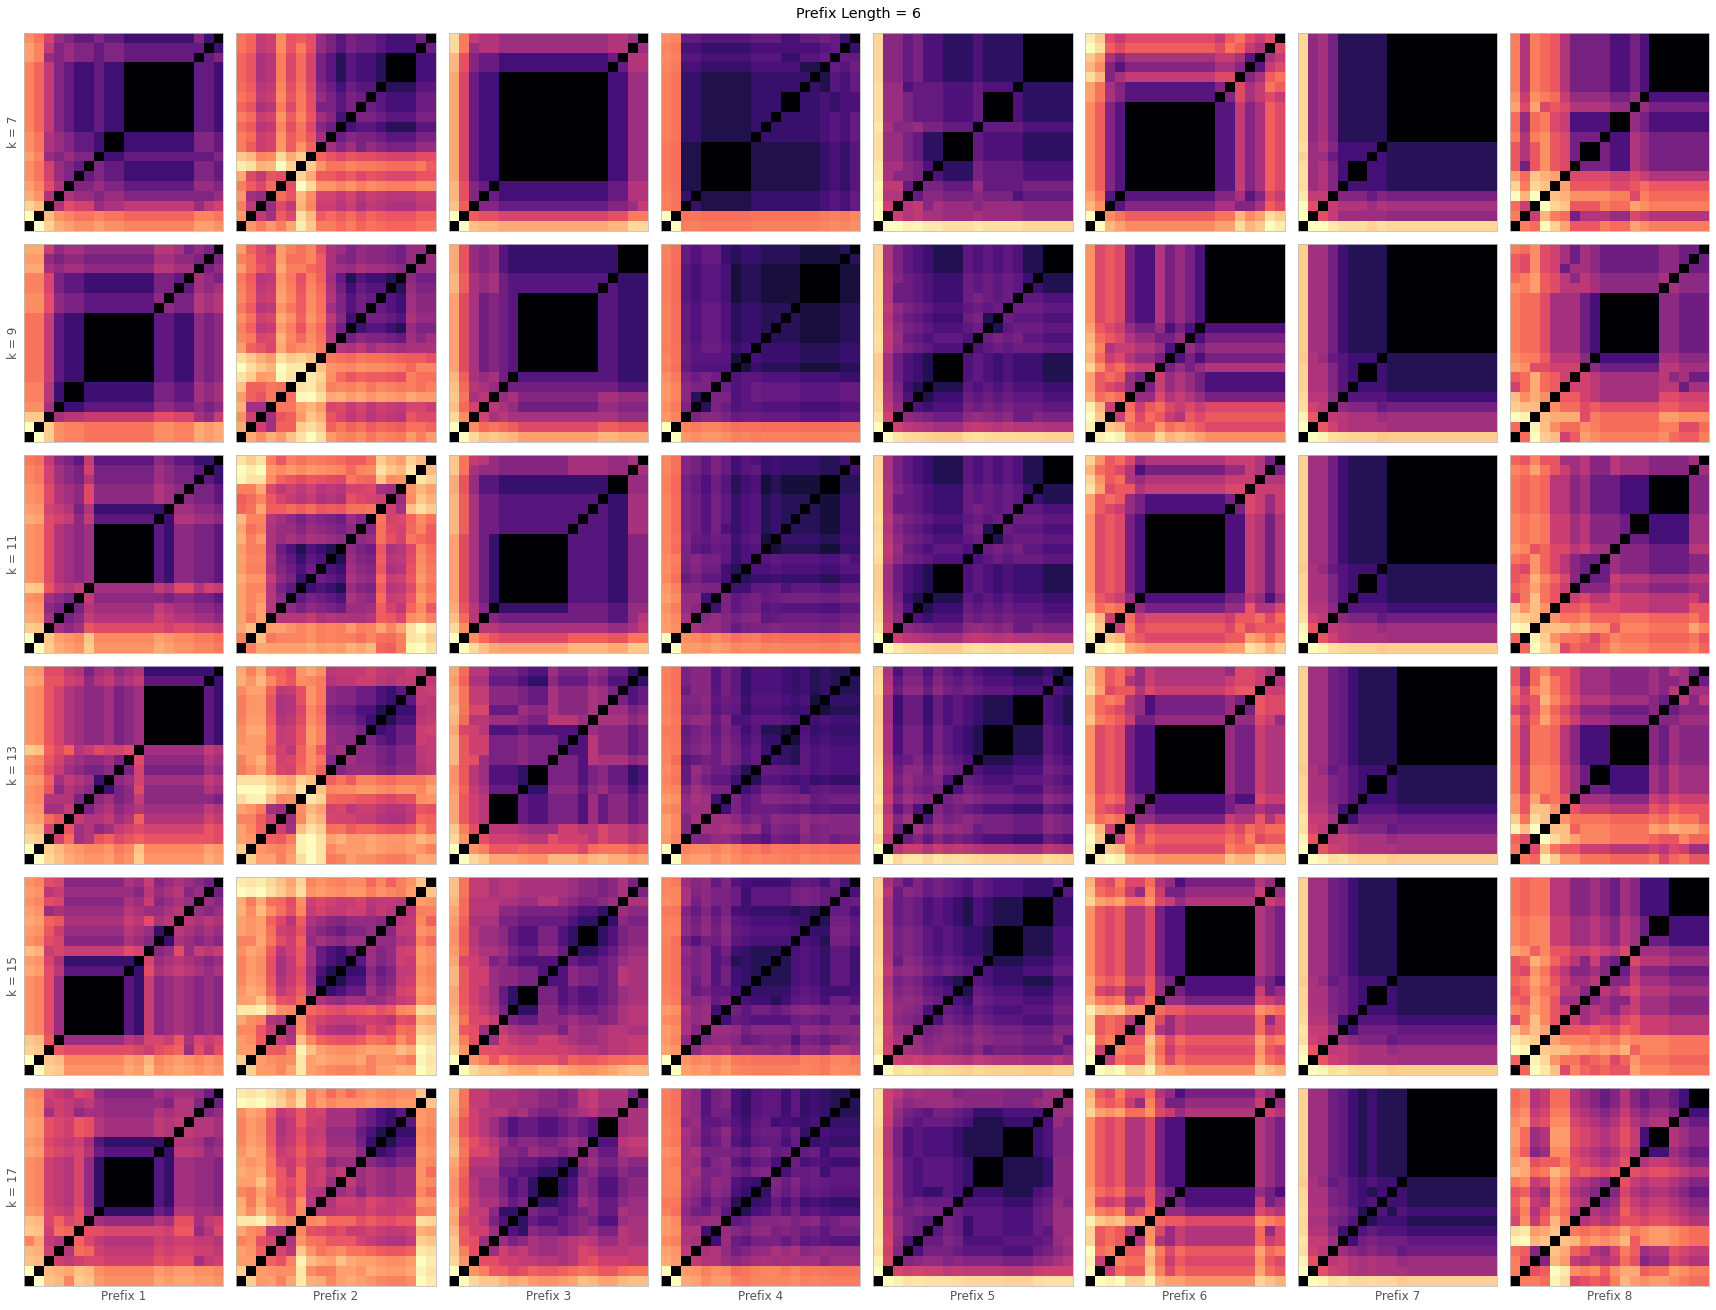

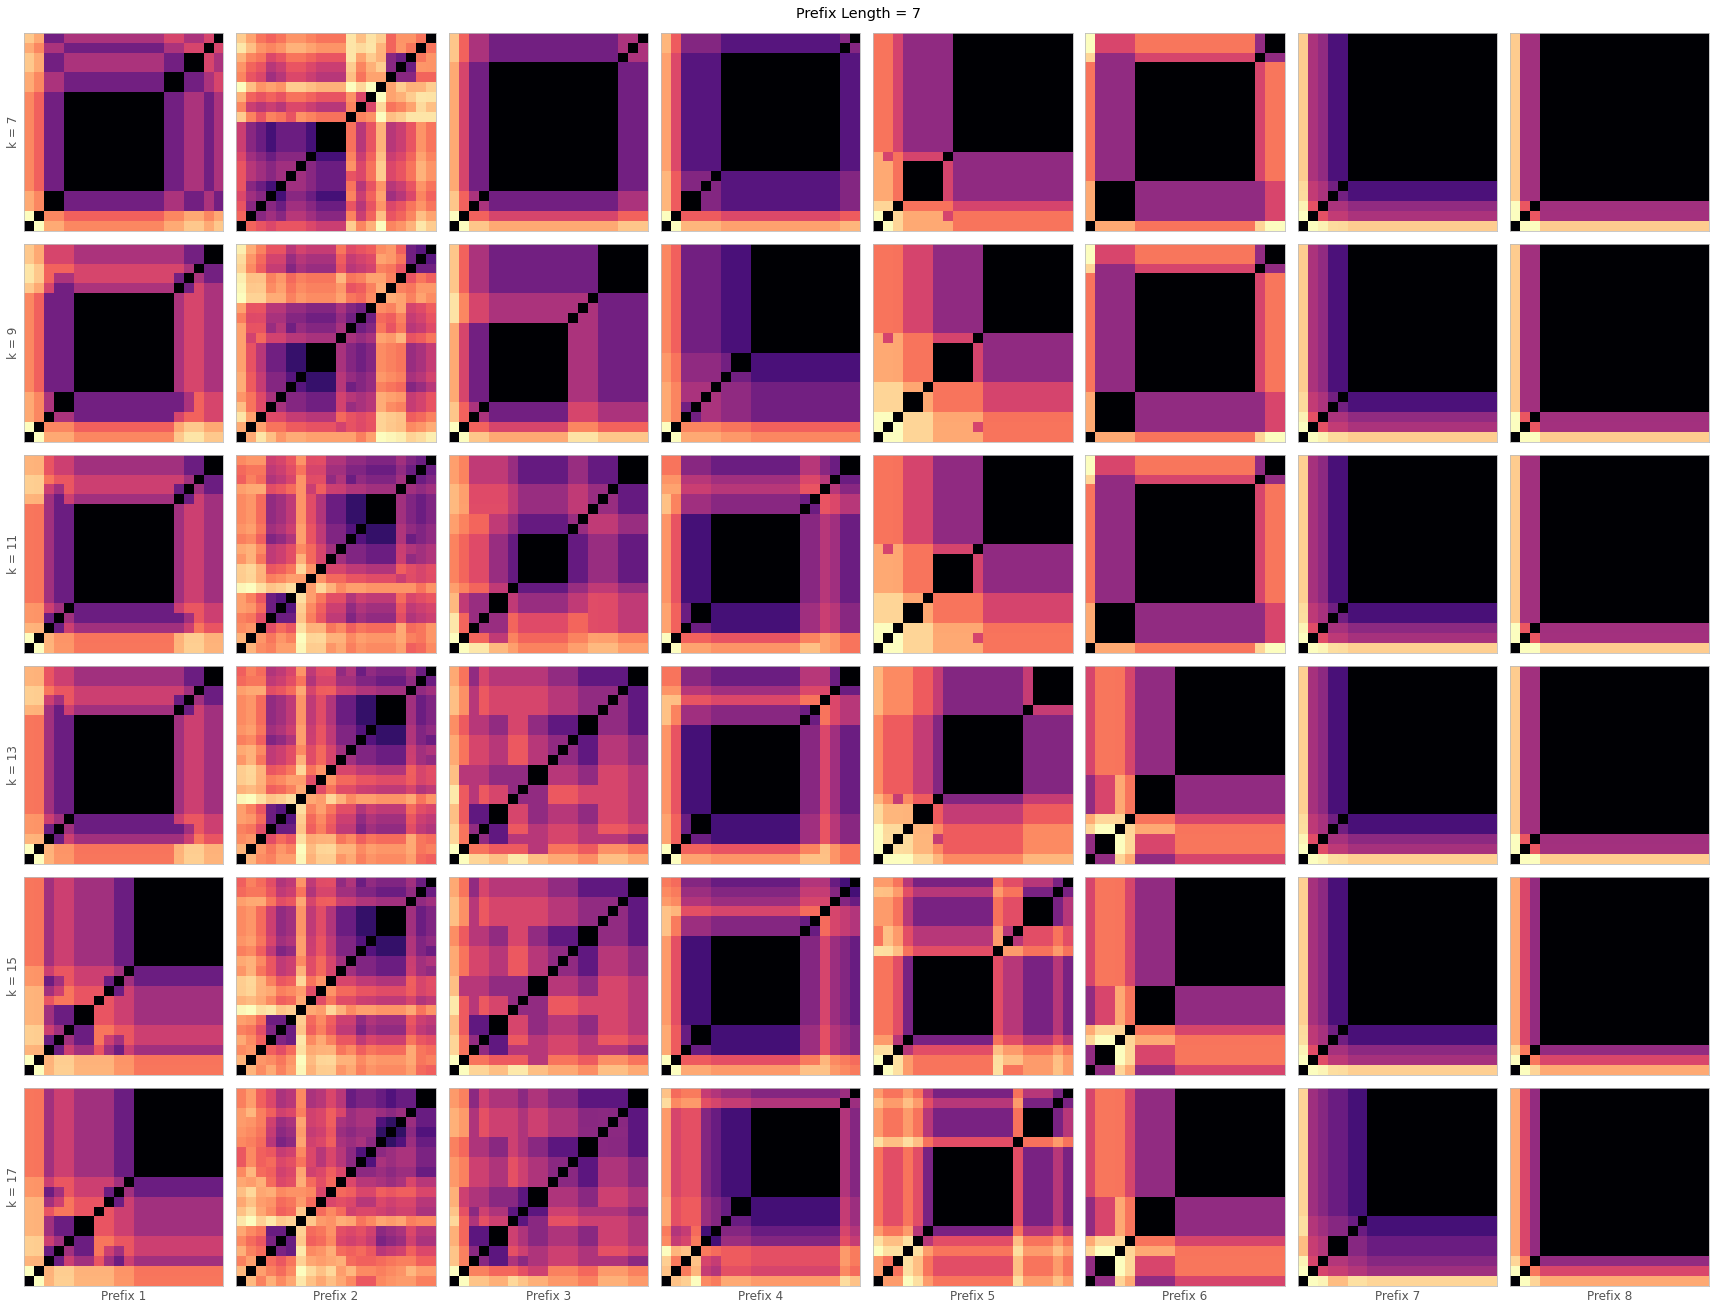

In [260]:
plen_vals, pver_vals, k_vals = params_df.index.levels

for plen in plen_vals:
    nrow = len(k_vals)
    ncol = len(pver_vals)
    size = 3
    fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * size, nrow * size), sharex=True, sharey=True)
    
    for i, k in enumerate(k_vals):
        for j, pver in enumerate(pver_vals):
            ax = axs[i, j]
            param = get_param(plen, pver, k)
            
            dmat = ds['gambit_dmat'].sel(param=param).values
            link = linkage(squareform(dmat), method='complete')
            dmat = order_dmat(dmat, link)
            
            ax.pcolormesh(np.sqrt(dmat))
        
    for ax, kval in zip(axs[:, 0], k_vals):
        ax.set_yticks([])
        ax.set_ylabel(f'k = {kval}')
    for ax, pver in zip(axs[-1, :], pver_vals):
        ax.set_xticks([])
        ax.set_xlabel(f'Prefix {pver + 1}')

    fig.tight_layout()
    fig.suptitle(f'Prefix Length = {plen}', y=1.01)

<AxesSubplot:>

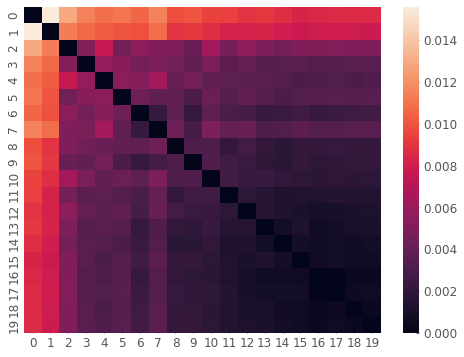

In [233]:
sns.heatmap(order_dmat(dmat, link))

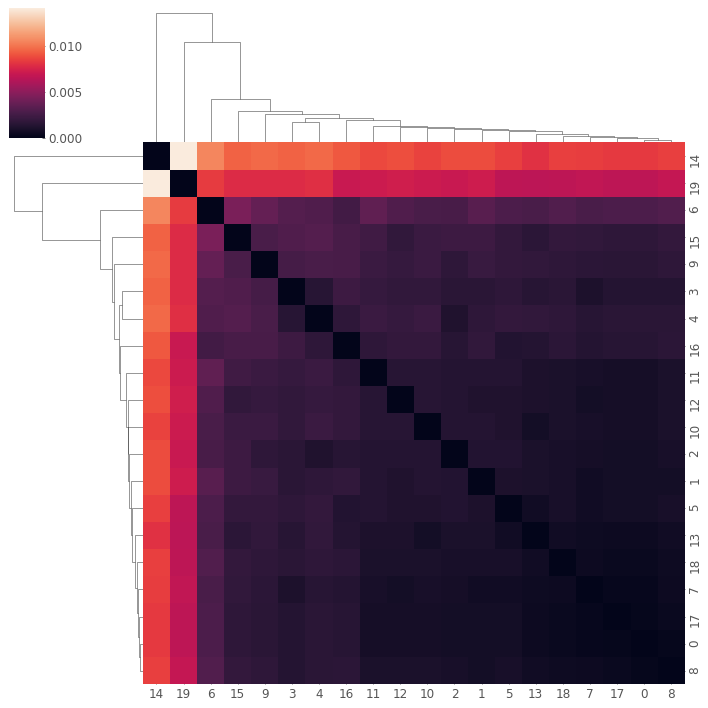

In [201]:
ds = genome_dss['snitkin_2012']
dmat = ds['gambit_dmat'].sel(param=gambitdb_param).values
link = linkage(squareform(dmat), method='average')

sns.clustermap(dmat, row_linkage=link, col_linkage=link)

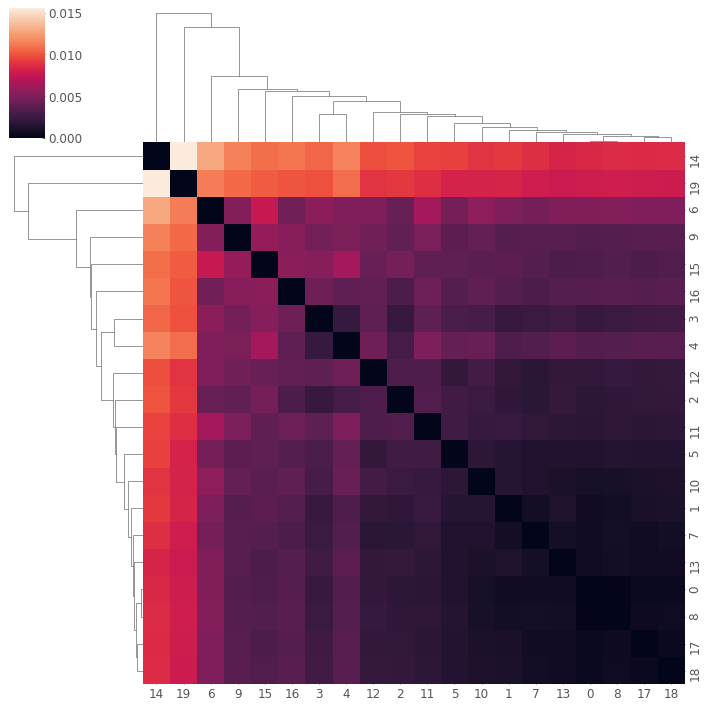

In [223]:
ds = genome_dss['snitkin_2012']
dmat = ds['gambit_dmat'].sel(param=get_param(4, 0, 11)).values
link = linkage(squareform(dmat), method='average')

sns.clustermap(dmat, row_linkage=link, col_linkage=link)